## CNN_LSTM Base
- to capture spatial (CNN) -temporal (LSTM) information
- often used in NEXT FRAME VIDEO PREDICTION problem in vision


### Sources

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9063513

https://keras.io/examples/vision/conv_lstm/

In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

import os
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)


sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-03-14 11:50:04.174964: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images_nfp(dir_name)
data_socat, pco2_socat = preprocess_images_nfp(dir_name, socat = True)

val_data,val_pco2 = preprocess_images_nfp(val_dir_name,"035")
val_data_socat,val_pco2_socat = preprocess_images_nfp(val_dir_name,"035",socat=True)


/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

y=np.expand_dims(pco2[X_index][1:],axis=4)
X=data[X_index][:-1]

val_y=np.expand_dims(val_pco2[X_index][1:],axis=4)
val_X=val_data[X_index][:-1]
print(X.shape, y.shape)

(418, 3, 180, 360, 6) (418, 3, 180, 360, 1)


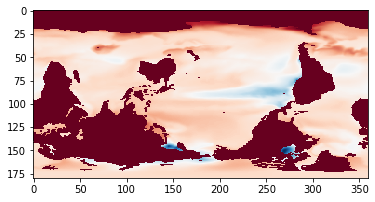

In [4]:
plt.imshow(y[0][0],cmap="RdBu", interpolation="nearest")

In [5]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=y[0].shape

INPUT_SHAPE

(3, 180, 360, 6)

In [29]:
tf.keras.backend.clear_session()

In [30]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [31]:
from tensorflow import keras
from tensorflow.keras import layers
from functools import partial

DefaultConvLSTM2D = partial(keras.layers.ConvLSTM2D,
                        filters=32, kernel_size=(5, 5),
                        padding="same",return_sequences=True,
                        activation="elu",)



model = keras.models.Sequential([
    DefaultConvLSTM2D(input_shape=INPUT_SHAPE),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(1,1)),
    keras.layers.Conv3D(filters = 1, kernel_size=(3,3,3),activation="elu", padding="same")
    
])


model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(),
)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8320      
_________________________________________________________________
conv3d (Conv3D)              (None, 3, 180, 360, 1)    865       
Total params: 205,025
Trainable params: 204,897
Non-trainable params: 128
________________________________________________

In [33]:
model_path="../../models/base_CNN_LSTM_new.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 20
batch_size = 8

# Fit the model to the training data.
hist = model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_X,val_y),
    callbacks=callbacks,
)

Epoch 1/20
53/53 [==============================] - 52s 888ms/step - loss: 78.3365 - val_loss: 26.7478
Epoch 2/20
53/53 [==============================] - 45s 844ms/step - loss: 16.5595 - val_loss: 19.5324
Epoch 3/20
53/53 [==============================] - 45s 845ms/step - loss: 8.5563 - val_loss: 34.8685
Epoch 4/20
53/53 [==============================] - 44s 843ms/step - loss: 6.8452 - val_loss: 27.5326
Epoch 5/20
53/53 [==============================] - 45s 843ms/step - loss: 6.2137 - val_loss: 13.8252
Epoch 6/20
53/53 [==============================] - 44s 843ms/step - loss: 5.8145 - val_loss: 12.7947
Epoch 7/20
53/53 [==============================] - 45s 844ms/step - loss: 4.7889 - val_loss: 8.5855
Epoch 8/20
53/53 [==============================] - 45s 844ms/step - loss: 4.5349 - val_loss: 6.0595
Epoch 9/20
53/53 [==============================] - 45s 845ms/step - loss: 4.3856 - val_loss: 12.3618
Epoch 10/20
53/53 [==============================] - 45s 844ms/step - loss: 4.1982

Text(0.5, 0, 'epoch')

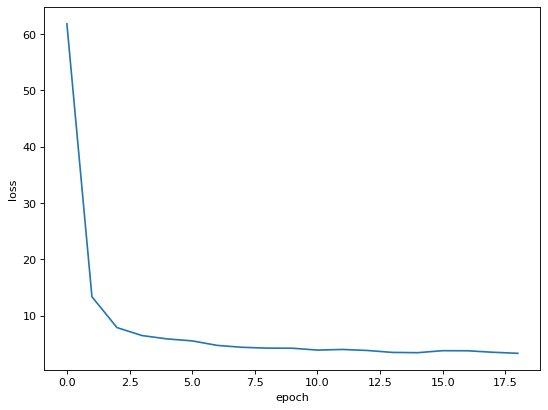

In [35]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(hist.history["loss"])
plt.ylabel('loss')
plt.xlabel('epoch')

In [38]:
best_model = tf.keras.models.load_model('../../models/base_CNN_LSTM_new.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_frames=best_model.predict(X,verbose=1)

14/14 [==============================] - 11s 707ms/step


In [39]:
predicted_frames[y==0]=0.0

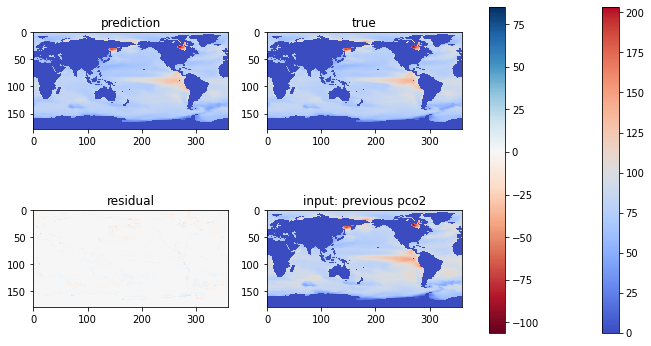

In [43]:
import imageio
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 2,figsize=(12, 6))

d = predicted_frames - y


norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)


img=axis[0][0].imshow(np.flipud(predicted_frames[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_frames[0][1]-y[0][1]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(X[0][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("input: previous pco2")

plt.savefig('../../assets/next-frame-prediction.png')

plt.show()




### Creating Gifs

In [45]:
filenames = []

for i in range(418):
    # plot the line chart
    figure, axis = plt.subplots(2, 2,figsize=(12, 6))

    img=axis[0][0].imshow(np.flipud(predicted_frames[i][1]),cmap="coolwarm", interpolation="nearest")
    axis[0][0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[0][1].imshow(np.flipud(y[i][1]),cmap="coolwarm", interpolation="nearest")
    axis[0][1].set_title("true")

    diff=np.flipud(np.squeeze(predicted_frames[i][1]-y[i][1]))
    img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
    axis[1][0].set_title("residual")
    plt.colorbar(img2,ax=axis)
    
    img2=axis[1][1].imshow(np.flipud(X[i][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
    axis[1][1].set_title("input: previous pco2")
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()


with imageio.get_writer('../../assets/cnn-lstm.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)


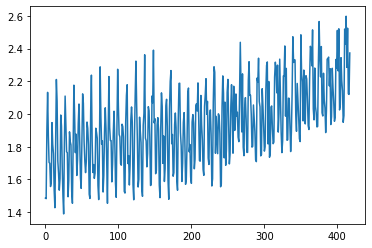

In [46]:
rmses = []

for i in range(418):    
    rmse = np.sqrt(np.mean((predicted_frames[i][1]-y[i][1])**2))
    rmses.append(rmse)
    
plt.plot(rmses)
plt.savefig('../../assets/nfp-overtime.png')

## Getting PCO2 Prediction per Point

In [48]:
def inverse_scale_image_nfp(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [49]:
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,tmp_pco2 = read_xarray(dir_name)
y_true,y_pred=inverse_scale_image_nfp(predicted_frames,tmp_pco2.pCO2.data)  

In [50]:
print("Scaled back RMSE score:")

np.sqrt(np.mean((y_true[:,:1]-y_pred[:,:1])**2))

Scaled back RMSE score:


5.1524237865056906

In [51]:
np.sqrt(np.sum((y_true[:,:1]-y_pred[:,:1])**2)/np.sum(y_pred!=0.0))

3.736595622328731